### Import Libraries

In [10]:
import pandas as pd
import numpy as np
import psycopg2
import os
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import requests
import zipfile
import shutil

### Downloading the data to be analyzed

In [3]:
conn = psycopg2.connect(
    host="zip_data_postgres_db",
    database=os.environ.get('POSTGRES_DB'),
    user=os.environ.get('POSTGRES_USER'),
    password=os.environ.get('POSTGRES_PASSWORD')
)

query = "SELECT * FROM reporting_results2020"
df = pd.read_sql_query(query, conn)

/tmp/ipykernel_393/2587181120.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


### Displaying a sample of downloaded data

In [4]:
df.head()

,id,numer_ewidencyjny_system,numer_ewidencyjny_urzad,data_wplywu_wniosku_do_urzedu,nazwa_organu,wojewodztwo_objekt,obiekt_kod_pocztowy,miasto,terc,cecha,...,kubatura,stan,jednostki_numer,obreb_numer,numer_dzialki,numer_arkusza_dzialki,nazwisko_projektanta,imie_projektanta,projektant_numer_uprawnien,projektant_pozostali
0,1,ST-SL-BI/ZGŁOSZENIE/1432/2020,Wb.6743.3.107.2020.KaM,2020-06-04 00:00:00,Starosta Powiatu Bielsko-Biała,śląskie,43-518,Ligota,2402045,,...,,Brak sprzeciwu,240204_5,0005,2395/8,,Świder,Katarzyna,SLK/4131/PWOS/12,
1,2,ST-SL-BI/ZGŁOSZENIE/1432/2020,Wb.6743.3.107.2020.KaM,2020-06-04 00:00:00,Starosta Powiatu Bielsko-Biała,śląskie,43-518,Ligota,2402045,,...,,Brak sprzeciwu,240204_5,0005,2395/5,,Świder,Katarzyna,SLK/4131/PWOS/12,
2,3,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26 00:00:00,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,...,,Brak sprzeciwu,241201_5,0004,1389/6,,Towarek,Grzegorz,SLK/2409/ZOOS/08,
3,4,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26 00:00:00,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,...,,Brak sprzeciwu,241201_5,0004,1727/10,,Towarek,Grzegorz,SLK/2409/ZOOS/08,
4,5,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26 00:00:00,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,...,,Brak sprzeciwu,241201_5,0004,1850/10,,Towarek,Grzegorz,SLK/2409/ZOOS/08,


### Categories of building permits

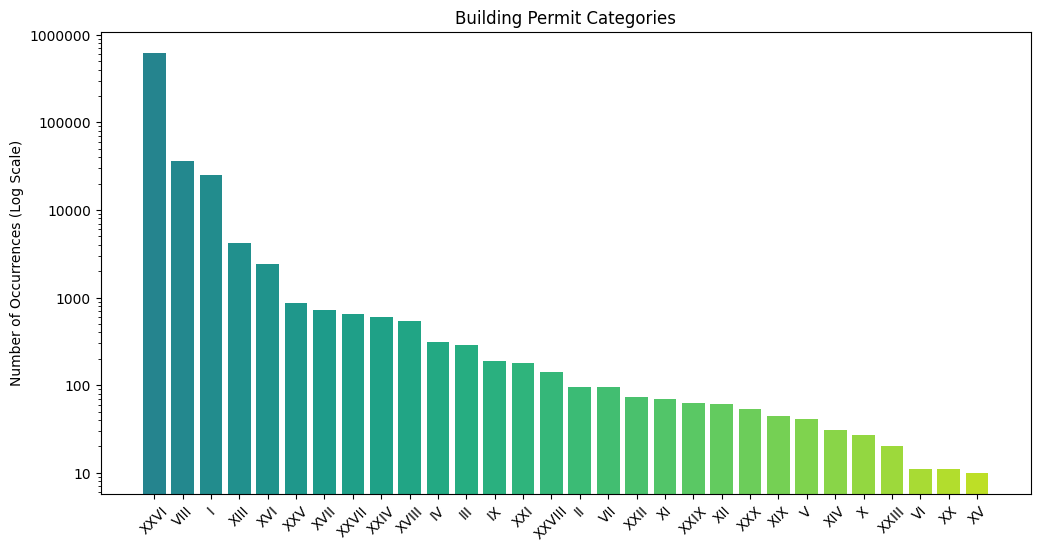

In [5]:
def categories_counter_log(df):
    counter = Counter()
    
    for record in df['kategoria']:
        counter[record] += 1

    # Sorting the data
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create color gradient for the plot
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Plot details
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45)
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Building Permit Categories')
    
    # Set Y-axis to logarithmic scale
    plt.yscale('log')

    # Format Y-axis labels as actual numbers instead of powers of 10
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

categories_counter_log(df)


### Names of construction intention type

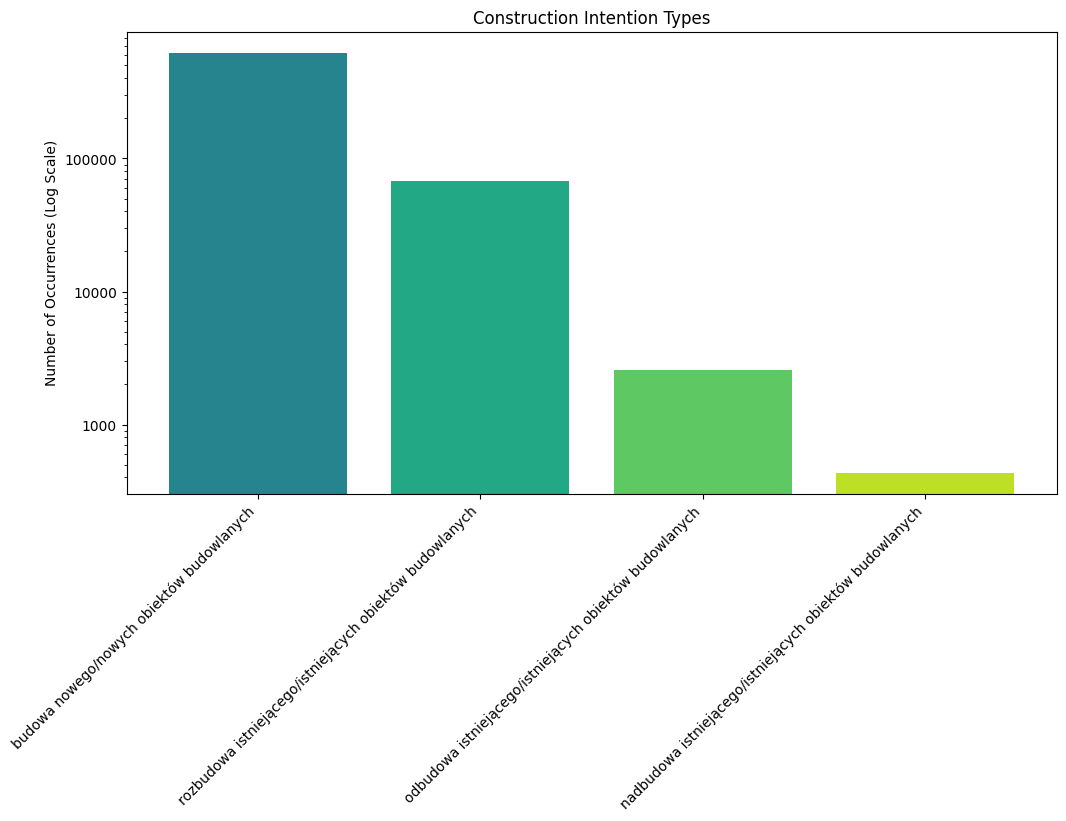

In [6]:
def construction_intention_counter_log(df, column_name):
    counter = Counter()
    
    for record in df[column_name]:
        counter[record] += 1
        
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Adjust np.linspace to match the number of categories in sorted_data
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')  
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Construction Intention Types')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

    plt.show()

construction_intention_counter_log(df, 'rodzaj_zam_budowlanego')


### Date of receipt of the build application (by month)

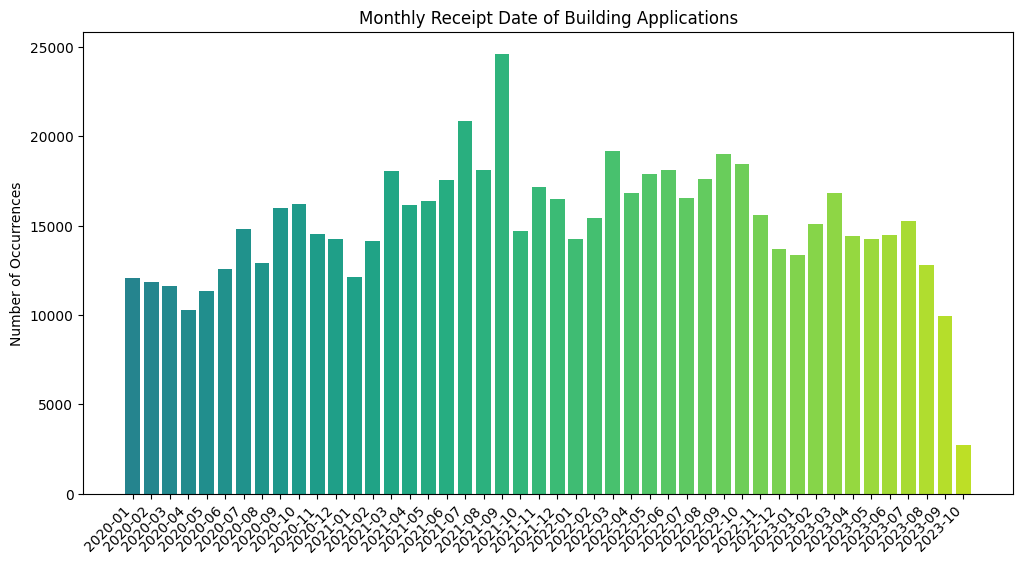

In [7]:
def monthly_receipt_date_counter(df, column_name):
    # Convert column to datetime
    df[column_name] = pd.to_datetime(df[column_name])

    # Group by year and month
    df['YearMonth'] = df[column_name].dt.to_period('M')

    # Count occurrences by month
    counter = Counter(df['YearMonth'])

    # Sort data by date (YearMonth) instead of occurrences
    sorted_data = dict(sorted(counter.items()))

    # Create the plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Convert PeriodIndex to string for plotting
    sorted_keys = [str(key) for key in sorted_data.keys()]
    plt.bar(sorted_keys, sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Occurrences')
    plt.title('Monthly Receipt Date of Building Applications')

    plt.show()

monthly_receipt_date_counter(df, 'data_wplywu_wniosku_do_urzedu')

### Teritorial units analyze

In [12]:
url = 'https://www.gis-support.pl/downloads/2022/wojewodztwa.zip?_ga=2.206480666.846252037.1701965194-1528073724.1696937803&_gl=1*7ppnim*_ga*MTUyODA3MzcyNC4xNjk2OTM3ODAz*_ga_6DGXL861WD*MTcwMjAzMDgyOS4xMC4xLjE3MDIwMzE4OTYuNTkuMC4w'
local_zip_path = 'zip_data.zip'
extract_to_folder = 'unpacked_zip_data_files'
shapefile_path = 'unpacked_zip_data_files/wojewodztwa.shp'

def download_and_unpack_zip(url, local_zip_path, extract_to_folder):
    # Start downloading the ZIP file
    print("Starting to download the ZIP file...")
    response = requests.get(url)
    
    # Save the downloaded ZIP file locally
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)
    
    # ZIP file downloaded, start extracting it
    print("ZIP file downloaded. Starting the extraction...")
    
    # Check if the extract_to_folder already exists
    if os.path.exists(extract_to_folder):
        print(f"Removing existing folder: {extract_to_folder}")
        shutil.rmtree(extract_to_folder)
    
    # Create the folder before extraction
    os.makedirs(extract_to_folder)
    
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
    
    # Extraction completed
    print("Extraction finished.")
    
    # Remove the downloaded ZIP file from the working directory
    os.remove(local_zip_path)

download_and_unpack_zip(url, local_zip_path, extract_to_folder)

gdf = gpd.read_file(shapefile_path)


Starting to download the ZIP file...
ZIP file downloaded. Starting the extraction...
Removing existing folder: unpacked_zip_data_files
Extraction finished.
